In [18]:
#import the most used things
print("importing...")
import deepchem as dc
import pandas as pd
import numpy as np
import optuna
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic

importing...


In [19]:
print("loading...")
tasks, data, transformers = dc.molnet.load_hopv(featurizer=dc.feat.RDKitDescriptors(), splitter = None)

loading...


In [20]:
#convert the dataset so that no more nan is present and selct the y-values of the homo gap toghether with the according wheigths

#converting the train set
X = np.nan_to_num(data[0].X, copy=True, nan=0.0)
Y = data[0].y[:,[0]]
w = data[0].w[:,[0]]

#add the cenverted data to new dataframe
new_data= dc.data.DiskDataset.from_numpy(X=X, y=Y, w=w, ids=data[0].ids, tasks = ["HOMO"])

#split the data in train and test samples
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(new_data)

In [27]:
## finetuning parameters
def get_model(trial):
    output_variance = trial.suggest_float('output_variance', 0.1, 10, log=True)
    length_scale = trial.suggest_float('length_scale', 1e-5, 1e5, log=True)
    noise_level = trial.suggest_float('noise_level', 1e-5, 1e5, log=True)

    params = {
        'kernel': output_variance**1 * RationalQuadratic(length_scale=length_scale, length_scale_bounds='fixed'), 
        'alpha': trial.suggest_float('alpha', 1e-12, 1e-5, log=True),
    }

    sklearn_gpr = GaussianProcessRegressor(**params)
    return dc.models.SklearnModel(sklearn_gpr)

def objective(trial):
    model = get_model(trial)
    model.fit(train_dataset)
    
    metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
    return model.evaluate(valid_dataset, [metric])['mean_squared_error']

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-03-01 14:43:41,106] A new study created in memory with name: no-name-7812268e-1434-4ad0-a18f-81deb6d18e13
c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
[I 2024-03-01 14:43:41,153] Trial 0 finished with value: 0.9179295984546836 and parameters: {'output_variance': 0.1584200314990352, 'length_scale': 50468.155059227094, 'noise_level': 0.1560057721206422, 'alpha': 8.513542

In [29]:
print(study.best_params)
print(study.best_params["output_variance"])

{'output_variance': 0.7803688879766852, 'length_scale': 1205.4132240943766, 'noise_level': 0.8843507780376777, 'alpha': 2.69590443807184e-11}
0.7803688879766852


In [30]:
#optimized values
output_variance = study.best_params["output_variance"]
length_scale = study.best_params["length_scale"]
noise_level = study.best_params["noise_level"]
kernel = output_variance**1 * RationalQuadratic(length_scale=length_scale, length_scale_bounds='fixed')
alpha = study.best_params["alpha"]

In [31]:
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, alpha=alpha,n_restarts_optimizer=100))
print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(valid_dataset)
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(valid_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

fitting model...


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


model is fitted
Training set score: {'pearson_r2_score': 0.217244547299233}
Test set score: {'pearson_r2_score': 0.04584598918414461}


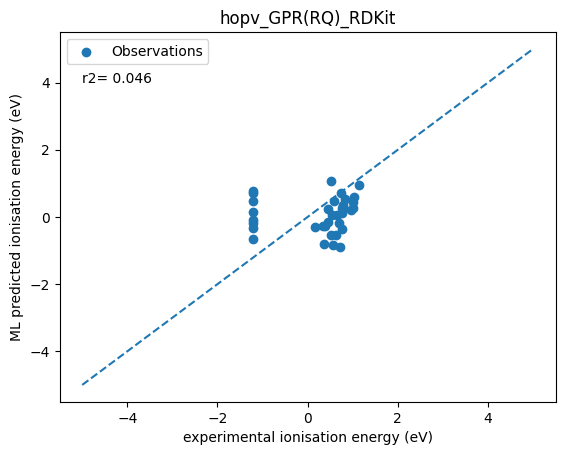

In [32]:
#convert tekst to string, so it can be depicted in matplotlib
number=list(test_score.values())[0]
text = "r2= "+ str(round(number,3))


#plot the data
import matplotlib.pyplot as plt

x=[-5,5]
y=[-5,5]
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label="Observations")
plt.legend()
plt.xlabel("experimental ionisation energy (eV)")
plt.ylabel("ML predicted ionisation energy (eV)")
plt.title("hopv_GPR(RQ)_RDKit")
plt.text(-5,4,text)
plt.show()